In [113]:
import src # make sure jupyter notebook is running in the environemnt with this project installed (pip install -r requirements.txt).
import pandas as pd
from pathlib import Path
from scipy import stats

project_dir = Path(src.__file__).parents[1]
data_dir = project_dir / 'data'

# Util function

In [75]:
def humanize(snake_case_string):
    return snake_case_string.replace('_', ' ')

# Analiza kadry medycznej
Na podstawie danych pobranych z BDL (bank danych ludności) prowadzonego przez główny urząd statystyczny chcemy przeanalizować jak zmieniała się kadra medyczna przez okres od 2010 roku do 2022.

In [91]:
def read_stats_folder(dir):
    data = [pd.read_csv(fname, index_col=0) for fname in dir.iterdir()]
    data = pd.concat(data, axis=1)
    return data 


def plot_bdl_stats(dir):
    data = read_stats_folder(dir)
    data.plot.bar(figsize=(10,10), 
                grid=True,
                title=f'{humanize(dir.name).capitalize()} variables')
    

In [82]:
folders_with_stats = list((data_dir / 'raw' / 'medical_staff_stats_bdl').iterdir())
# Display stats that were collected from BDL
for i, var_name in enumerate(f.stem for f in folders_with_stats):
    print(f'Folder with {humanize(var_name)} stats has idx {i}')

Folder with medical staff stats has idx 0
Folder with midwives stats has idx 1
Folder with nurses stats has idx 2
Folder with rescuers stats has idx 3


# Analiza danych dla lekarzy pracujących w szpitalach


## Analiza liczebności

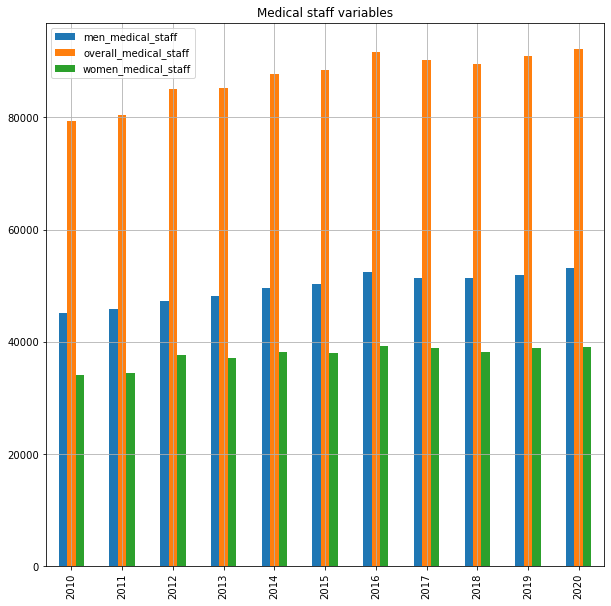

In [90]:
STATS_FOLDER_IDX = 0
plot_bdl_stats(folders_with_stats[STATS_FOLDER_IDX])


Na powyższym wykresie widzimy wzrost liczby lekarzy w latach od 2010 do 2018. W 2016 tendencja się odwraca i liczba spada aż do 2018, po czym znowu się odwraca. Ostatni pomiar zrobiony w 2020 pokazuje, że liczba lekarzy jest prawie równa tej która była przed 2016 rokiem.
Inną zauważalną cechą jest to, że większość lekarzy są mężczyznami. W dalszej części zostanie przeprowadzona trochę bardziej rzetelna analiza uzależniona od płci.

In [103]:
data = read_stats_folder(folders_with_stats[STATS_FOLDER_IDX])
MEN_COLUMN = 'men_medical_staff'
WOMEN_COLUMN = 'women_medical_staff'
OVERALL_COLUMN = 'overall_medical_staff'

## Analiza z podziałem na płeć

In [122]:
from collections import defaultdict
percentages = defaultdict(list)
for year, row in  data.iterrows():
    men_percentage = ((row[MEN_COLUMN] / row[OVERALL_COLUMN]) * 100).round().astype('int')
    women_percentage = ((row[WOMEN_COLUMN] / row[OVERALL_COLUMN]) * 100).round().astype('int')
    percentages[MEN_COLUMN].append(men_percentage)
    percentages[WOMEN_COLUMN].append(women_percentage)
    print(f'[{year}] - men: {men_percentage} %, women: {women_percentage} %, abs(men % - women %): {abs(men_percentage - women_percentage)} %')

print(f'Women mode: {stats.mode(percentages[MEN_COLUMN]).mode[0]} %')
print(f'Men mode: {stats.mode(percentages[WOMEN_COLUMN]).mode[0]} %')

[2010] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2011] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2012] - men: 56 %, women: 44 %, abs(men % - women %): 12 %
[2013] - men: 56 %, women: 44 %, abs(men % - women %): 12 %
[2014] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2015] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2016] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2017] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2018] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2019] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2020] - men: 58 %, women: 42 %, abs(men % - women %): 16 %
Women mode: 57 %
Men mode: 43 %


Wnioski wynikające z powyższego podsumowania:
- procentowy udział mężczyzn jest zawsze conajmniej o 11 % większy od udziału kobiet
- przez okres 10 badanych lat nie było dużych zmian w procentowym udziale żadnej z płci. Pomiary oscylowały wokół wartości 57% dla mężczyzn oraz 43% dla kobiet.
- oscylacje nie są skorelowane z zmianami trendów wśród liczby lekarzy. W celach przypomnienienia powiem, że zmiany trendów liczebności były spostrzegane w 2016 oraz 2018 latach. Natomiast oscylacje w procentowym udziale widzimy w 2012, 2013 oraz 2020.

## Dalsze pytania

Po wykonaniu powyższej analizy pojawiają się następujące sensowne pytania:

- dlaczego procentowy udział kobiet jest mniejszy od procentowego udziały mężczyzn?
- dlaczego wiedzieliśmy odwrócenie trendu wzrostu wśród lekarzy w 2016 oraz 2018 latach?

W dalszych sekcjach będzie podjęta próba odpowiedzi na te pytania.

# Dlaczego procentowy udział kobiet jest mniejszy od procentowego udziały mężczyzn?


## Demograficzny skład Polski 

Możliwe, że powód takiego podziału jest naturalny i wynika z demograficznego składu Polski. 

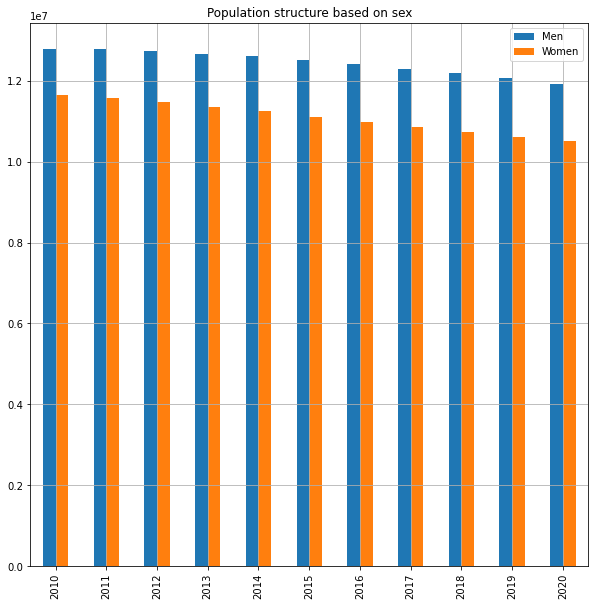

In [141]:
population_structure_over_years = pd.read_csv(data_dir / 'external' / 'ludnosc_wg_plci_w_wieku_produkcyjnym.csv', index_col=0)

_ = population_structure_over_years.plot.bar(
    figsize=(10, 10),
    title='Population in working age structure based on sex',
    grid=True,
)

Powyższy wykres uwzględnia tylko ludzi w wieku produkcyjnym (czyli mężczyzn od 18 do 64 lat oraz kobiet od 18 do 59).
Z wykresu jasno widać, że mężczyzn w spółeczeństwie jest więcej co tłumaczy dlaczego zawód lekarza jest bardziej popularny wśród mężczyzn niż wśród kobiet. 

Nie mniej jednak, ten wykres robi tylko ciekawszym pytanie o tym dlaczego widzieliśmy zmiany trendu w 2016 oraz 2018 latach, oraz pytanie dlaczego widzimy w danych rosnący trend, ponieważ widzimy, że liczba osób w wieku produkcyjnym maleje przez cały badany okres.